In [ ]:
!pip install pydrive
!pip install gensim
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id':'1m50raYcuWAVBtsRzHS7rYcZYVW9-oYEx'})
download.GetContentFile('fake_or_news.csv') 

In [ ]:
%matplotlib inline

import sqlite3                          # for sql database
import pandas as pd
import numpy as np
import nltk                             # nltk:- Natural Language Processing Toolkit
import string
import re
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [ ]:
df = pd.read_csv('fake_or_news.csv')

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
df.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [ ]:
df.shape

(6335, 4)

In [ ]:
df['label'].size


6335

In [ ]:
df['label_num'] = df['label'].map(lambda x: 1 if x == "REAL" else 0)

In [ ]:
df.head()

,Unnamed: 0,title,text,label,label_num
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


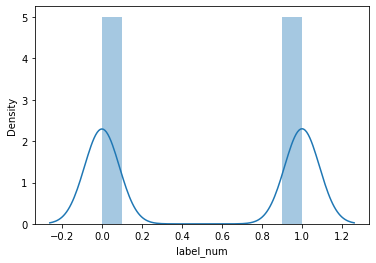

In [ ]:
sns.distplot(df['label_num'],bins=10)
plt.show()

**1.) Data Cleaning**

In [ ]:
df.duplicated(subset={"title"}).value_counts()

False    6256
True       79
dtype: int64

In [ ]:
df.duplicated(subset={"title"}).value_counts()

False    6256
True       79
dtype: int64

In [ ]:
# Deleting the duplicates
df1 =  df.drop_duplicates(subset={"title"},keep="first")

In [ ]:
df1.duplicated(subset={"title"}).value_counts()

False    6256
dtype: int64

**2.) Text Preprocessing**

(i) HTML Tage Removal

In [ ]:
import re
# cleaning html symbols from the sentence
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

(ii) Punctuations Removal

In [ ]:
# cleaning punctuations from the sentence
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

(iii) Stopwords

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few',

(iv) Stemming

In [ ]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer

In [ ]:
print(snow.stem('Secretary')) #same meaning word with different spellings

secretari


**PreProcessing on all the news**

In [ ]:
i = 0
string1 = ' '
final_string = []
fake_words = []                
real_words = []
s = ''

for sent in df1['text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    sent = cleanpunc(sent)
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):  
            if(w.lower() not in stop):    # If it is a stopword
                s = (snow.stem(w.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (df1['label'].values)[i] == 'REAL':
                    real_words.append(s)
                if(df1['label'].values)[i] == 'FAKE':
                    fake_words.append(s)
            else:
                continue
        else:
            continue 
    string1 = b" ".join(filtered_sentence) 
    final_string.append(string1)
    i += 1

**Fake and Real words in text**

In [ ]:
from collections import Counter
print("Number of Real words: ", len(real_words))
print("Number of Fake words: ", len(fake_words))

Number of Real words:  1467750
Number of Fake words:  1082029


In [ ]:
df1['CleanedText'] = final_string
df1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,title,text,label,label_num,CleanedText
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,b'daniel greenfield shillman journal fellow fr...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,b'googl pinterest digg linkedin reddit stumble...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,b'secretari state john kerri said monday stop ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0,b'kayde king novemb lesson tonight dem time de...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1,b'primari day new york hillari clinton donald ...


In [ ]:
# without stem
i = 0
string1 = ' '
final_string_nostem = []
s = ''

for sent in df1['text'].values:
    filtered_sentence=[]
    sent = cleanhtml(sent)
    sent = cleanpunc(sent)
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):  
            if(w.lower() not in stop):
                s = w.lower().encode('utf8')
                filtered_sentence.append(s)
            else:
                continue
        else:
            continue 
    string1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(string1)
    i += 1

In [ ]:
df1['CleanedText_NoStem'] = final_string_nostem

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df1.head(3)

,Unnamed: 0,title,text,label,label_num,CleanedText,CleanedText_NoStem
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,b'daniel greenfield shillman journal fellow fr...,b'daniel greenfield shillman journalism fellow...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,b'googl pinterest digg linkedin reddit stumble...,b'google pinterest digg linkedin reddit stumbl...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,b'secretari state john kerri said monday stop ...,b'secretary state john kerry said monday stop ...


**Avg Word2Vec**

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from gensim.models import Word2Vec
class w2v(TransformerMixin, BaseEstimator):

    def __init__(self, size=100, alpha=0.025, window=5, min_count=10, max_vocab_size=None, sample=1e-3, seed=1,
                 workers=3, min_alpha=0.0001, sg=1, hs=0, negative=5, cbow_mean=1, iter=10, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000):
        """
        Sklearn wrapper for Word2Vec model. See gensim.models.Word2Vec for parameter details.
        """
        self.model = None
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.cbow_mean = int(cbow_mean)
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words

    def fit(self, X, y=None):
        """
        Fit the model according to the given training data.
        Calls gensim.models.Word2Vec
        """
        X_tokenized = X.apply(lambda sent: sent.split())
        
        self.model = Word2Vec(
            sentences=X_tokenized, size=self.size, alpha=self.alpha,
            window=self.window, min_count=self.min_count, max_vocab_size=self.max_vocab_size,
            sample=self.sample, seed=self.seed, workers=self.workers, min_alpha=self.min_alpha,
            sg=self.sg, hs=self.hs, negative=self.negative, cbow_mean=self.cbow_mean, 
            iter=self.iter, null_word=self.null_word, trim_rule=self.trim_rule,
            sorted_vocab=self.sorted_vocab, batch_words=self.batch_words
        )
        return self

    def transform(self, X):
        return X.apply(self.avg_word_vector)
    
    def avg_word_vector(self, sent):
        """
        Returns an average word vector 
        from list of words
        if words are not in the wordvector
        vocabulary or in wordlist is 
        empty then returns a zero vector
        """
        word_list = sent.split()
        sent_vec = np.zeros(self.size)
        word_cnt = 0
        for word in word_list:
            try:
                vec = self.model.wv[word]
                sent_vec += vec
                word_cnt += 1
            except KeyError:
                pass
        if word_cnt != 0:
            sent_vec /= word_cnt
        return pd.Series(sent_vec)
    
    def most_similar(self, word):
        return self.model.wv.most_similar(word)
    
    def vocabulary(self):
        """
        Returns a Dataframe with 
        word as index and rows as vectors
        """
        # build a list of the terms, integer indices,
        # and term counts from the word2vec model vocabulary
        ordered_vocab = [(term, voc.index, voc.count)
                         for term, voc in self.model.wv.vocab.items()]

        # sort by the term counts, so the most common terms appear first
        ordered_vocab = sorted(ordered_vocab, key=lambda k : k[2], reverse=True)

        # unzip the terms, integer indices, and counts into separate lists
        ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

        # create a DataFrame with the word vectors as data,
        # and the terms as row labels
        wordvectors = pd.DataFrame(self.model.wv.vectors_norm[term_indices, :],
                                    index=ordered_terms)

        return wordvectors

In [ ]:
w2v_model = w2v()

w2v_features = w2v_model.fit_transform(df1['text'])
w2v_features.shape

(6256, 100)

In [ ]:
from sklearn import preprocessing
avg_w2v_norm = preprocessing.normalize(w2v_features)

In [ ]:
# spliting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(avg_w2v_norm,df1['label'],
                                                   test_size=0.3, shuffle=False)

**Logistic Regression**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.9003729355354289


In [ ]:
# Column standardization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([('Scalar', StandardScaler(with_mean=False)),
               ('logreg', LogisticRegression())])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))


Accuracy on test set: 0.9243473628129995


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.model_selection import GridSearchCV

def search_param(clf, param_grid, X, y, test_size=0.3, cv=10, n_jobs=-1,
                 random_search=False, n_iter=10, return_train_score=False):
    """
    Splits the data using time based slicing
    Performs grid search to search for optimal parameter
    using exaustive or random search
    Print accuracy and classification report with
    best parameter on test set
    """
    
    # time based splitting of dataset
    X_train, X_test, y_train, y_test = train_test_split_by_time(X, y, test_size)
    
    if random_search:
        grid_search = RandomizedSearchCV(clf, param_grid, n_iter=n_iter, 
                                         n_jobs=n_jobs, verbose=1, cv=cv, 
                                         return_train_score=return_train_score)
    else:
        grid_search = GridSearchCV(clf, param_grid, n_jobs=n_jobs, 
                                   verbose=1, cv=cv, 
                                   return_train_score=return_train_score)
    
    print('Performing grid search...\n')
    print('Parameters:')
    print(param_grid)
    print()
    
    grid_search.fit(X_train, y_train)
    print('\n')
    
    print("Best CV score: %f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("\nTest score with best_estimator_: %f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("                 Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    
    return grid_search

In [ ]:
def train_test_split_by_time(X, y, test_ratio = 0.3):
    """
    y parameter needs to be a pandas series
    with timestap as its index
    """
    
    train_ratio = 1 - test_ratio
    train_end = int(train_ratio * len(y))
    
    sorted_index = y.index.argsort()
    train_index = sorted_index[:train_end]
    test_index = sorted_index[train_end:]
    
    try:
        return X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]
    except KeyError:
        # if X is a pandas data structure
        return X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

In [ ]:
class power_uniform():
    def __init__(self, low=0.0, high=1.0, base=10.0):
        self.low = low
        self.high = high
        self.base = base

    def rvs(self, random_state):
        return self.base ** np.random.uniform(self.low, self.high)

In [ ]:
# optimal C for l2 regularization
param_grid = {
    'log__C': power_uniform(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('log', LogisticRegression(penalty='l2'))
])

best_log = search_param(clf, param_grid, w2v_features, df1['label'], random_search=True)

Performing grid search...

Parameters:
{'log__C': <__main__.power_uniform object at 0x7f6a713dac10>}

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Best CV score: 0.928750
Best parameters set:
	log__C: 98.04642762944088

Test score with best_estimator_: 0.926478


                 Classification Report Test Data
              precision    recall  f1-score   support

        FAKE       0.93      0.92      0.93       946
        REAL       0.92      0.93      0.93       931

    accuracy                           0.93      1877
   macro avg       0.93      0.93      0.93      1877
weighted avg       0.93      0.93      0.93      1877



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


**Support Vector Machine**


In [ ]:
from sklearn.svm import SVC
X_sample, X_sam, y_sample, y_sam = train_test_split(w2v_features, df1['label'], train_size=0.04)

In [ ]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split_by_time(X_sample, y_sample)

In [ ]:
# Train model with default hyperparameter
clf = SVC()
clf.fit(X_train, y_train)

print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.7866666666666666


In [ ]:
# Column standardization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([('Scalar', StandardScaler(with_mean=False)),
               ('svc', SVC())])
clf.fit(X_train, y_train)
print('Accuracy on test set:', clf.score(X_test, y_test))

Accuracy on test set: 0.7866666666666666


In [ ]:
# Using Random search
param_grid = {
    'svc__C': power_uniform(-4, 4),
    'svc__gamma': power_uniform(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('svc', SVC())
])

best_svm = search_param(clf, param_grid, X_sample, y_sample, random_search=True, n_iter=20)

Performing grid search...

Parameters:
{'svc__C': <__main__.power_uniform object at 0x7f6a711593d0>, 'svc__gamma': <__main__.power_uniform object at 0x7f6a71159790>}

Fitting 10 folds for each of 20 candidates, totalling 200 fits


Best CV score: 0.931046
Best parameters set:
	svc__C: 258.28138123187216
	svc__gamma: 0.20715961645246253

Test score with best_estimator_: 0.826667


                 Classification Report Test Data
              precision    recall  f1-score   support

        FAKE       0.83      0.85      0.84        40
        REAL       0.82      0.80      0.81        35

    accuracy                           0.83        75
   macro avg       0.83      0.82      0.83        75
weighted avg       0.83      0.83      0.83        75



In [ ]:
# Using Grid search
param_grid = {
    'svc__C': 10.0 ** np.arange(-4, 4),
    'svc__gamma': 10.0 ** np.arange(-4, 4)
}

clf = Pipeline([
    ('norm', Normalizer()),
    ('svc', SVC())
])

best_svm = search_param(clf, param_grid, X_sample, y_sample)

Performing grid search...

Parameters:
{'svc__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'svc__gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

Fitting 10 folds for each of 64 candidates, totalling 640 fits


Best CV score: 0.924837
Best parameters set:
	svc__C: 1000.0
	svc__gamma: 1.0

Test score with best_estimator_: 0.813333


                 Classification Report Test Data
              precision    recall  f1-score   support

        FAKE       0.81      0.85      0.83        40
        REAL       0.82      0.77      0.79        35

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.81      0.81      0.81        75



**K Nearest Neighbor**


The optimal number of neighbors is 7.


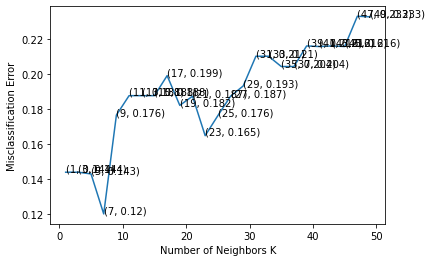

the misclassification error for each k value is :  [0.144 0.144 0.143 0.12  0.176 0.188 0.188 0.188 0.199 0.182 0.187 0.165
 0.176 0.187 0.193 0.21  0.21  0.204 0.204 0.216 0.216 0.216 0.216 0.233
 0.233]


In [ ]:
# loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

#creating odd list of K for KNN

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [ ]:
# KNN with k = optimal_k 
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 73.333333%


In [ ]:
pip install --exists-action=i scikit-learn

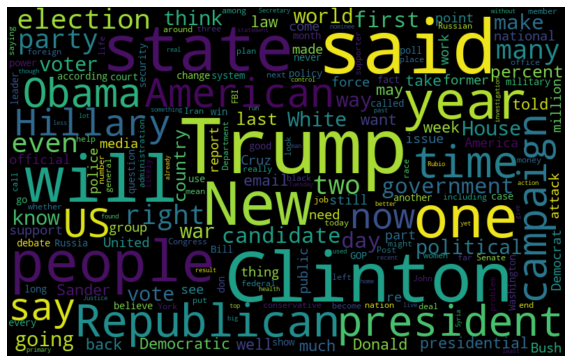

In [ ]:
# Word cloud for news
from wordcloud import WordCloud

all_data = df1
all_words = ' '.join([text for text in all_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

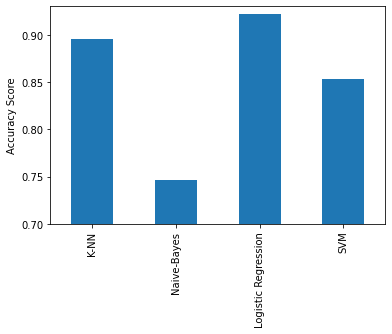

In [ ]:
model_accuracy = {
    'K-NN': 0.8961,
    'Naive-Bayes': 0.7464,
    'Logistic Regression': 0.9222,
    'SVM': 0.8533
}

pd.Series(model_accuracy).plot(kind='bar')
plt.ylabel('Accuracy Score')
plt.ylim((0.70, 0.93));